In [1]:
import os
import glob
import tensorflow as tf
import numpy as np
import dask
import dask.array as da
from PIL import Image
from skimage.transform import resize
from matplotlib import pyplot as plt
import scipy
from sklearn.metrics import accuracy_score
%matplotlib inline
np.set_printoptions(threshold=10000, linewidth=32)

ModuleNotFoundError: No module named 'skimage'

In [1]:
from jupyter_core.paths import jupyter_data_dir
print(jupyter_data_dir())

/home/skyolia/.local/share/jupyter


In [2]:
import sys
sys.executable

'/home/skyolia/anaconda3/envs/tensorflow_gpuenv/bin/python'

In [2]:
y = np.asarray(sorted(glob.glob("/home/skyolia/JupyterProjects/data/BASE-CYTO/images etiquetées/*.bmp")))
x = np.asarray(sorted(glob.glob("/home/skyolia/JupyterProjects/data/BASE-CYTO/images originales/*.bmp")))

In [3]:
train = [18, 19, 20, 21, 22, 23,
        24, 25, 26, 27, 28, 29,
        30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41,
        42, 43, 44, 45, 46, 47,
        48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59,
        60, 61, 62, 63, 64, 65,
        66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77,
        78, 79, 80, 81, 82, 83,
        84, 85, 86]
test = [0,  1,  2,  3,  4,  5,
         6,  7,  8,  9, 10, 11,
        12, 13, 14, 15, 16, 17]
#train_x, train_y = x[train], y[train]
#test_x, test_y = x[test], y[test]
#train_x, train_y, test_x, test_y

In [4]:
def padding(obj, i):
    pad_size = np.asarray(obj) - np.asarray(i.shape)
    padded = np.pad(i, ((0, pad_size[0]), (0, pad_size[1]), (0, pad_size[2])), mode='edge')
    return padded

def extract_patch_single_image(i, crop_size):
    crops = []
    height, width = i.shape[0], i.shape[1]
    for h in range(0, height, 25):
        for w in range(0, width, 25):
            image = i[h:h+crop_size[0], w:w+crop_size[1], :]
            image = padding((crop_size[0], crop_size[1], image.shape[2]), image) if image.shape[0:2] != crop_size else image
            crops.append(image)
    return np.asarray(crops)

def load_save(path, mode, crop_size, new_shape=None):
    #image = Image.open(path).convert(mode)
    image = scipy.ndimage.imread(path, mode=mode)
    image = np.asarray(image)#/255.0
    image = image[:, :, np.newaxis] if image.ndim == 2 else image
    image = extract_patch_single_image(image, crop_size) if crop_size else image
    image = resize(image, new_shape, preserve_range = True) if new_shape else image
    return image#.astype(int)

def data_processing(data_paths, crop_size, new_shape, mode, chunk, stack=True):
    x = []
    for i in data_paths:
        image = dask.delayed(load_save)(i, mode, crop_size, new_shape=None)
        x.append(da.from_delayed(image, new_shape, dtype=int))
    res = da.stack(x, axis=0).rechunk(chunk) if stack else da.concatenate(x, axis=0).rechunk(chunk)
    return res

train_x = data_processing(x[train], (32, 32), (1271, 32, 32, 3), 'RGB', (15000, 32, 32, 3), False)
train_y = data_processing(y[train], (32, 32), (1271, 32, 32, 1), 'L', (15000, 32, 32, 1), False)
#colored_train_y = data_processing(masks[train], (32, 32), (7400, 32, 32, 3), 'RGB', (10000, 32, 32, 3), False)
test_x = data_processing(x[test], None, (768, 1024, 3), 'RGB', (1, 768, 1024, 3))
test_y = data_processing(y[test], None, (768, 1024, 1), 'L', (1, 768, 1024, 1))
colored_test_y = data_processing(y[test], None, (768, 1024, 3), 'RGB', (1, 768, 1024, 3))
train_x, train_y, test_x, test_y, colored_test_y

(dask.array<rechunk-merge, shape=(87699, 32, 32, 3), dtype=int64, chunksize=(15000, 32, 32, 3)>,
 dask.array<rechunk-merge, shape=(87699, 32, 32, 1), dtype=int64, chunksize=(15000, 32, 32, 1)>,
 dask.array<stack, shape=(18, 768, 1024, 3), dtype=int64, chunksize=(1, 768, 1024, 3)>,
 dask.array<stack, shape=(18, 768, 1024, 1), dtype=int64, chunksize=(1, 768, 1024, 1)>,
 dask.array<stack, shape=(18, 768, 1024, 3), dtype=int64, chunksize=(1, 768, 1024, 3)>)

In [5]:
#train_y = da.where(train_y==118, 117, train_y)
%time da.unique(train_y).compute(), da.unique(test_y).compute()

/home/skyolia/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


CPU times: user 3.66 s, sys: 1.82 s, total: 5.47 s
Wall time: 6.34 s


(array([  0,  59, 117, 177],
       dtype=uint8), array([  0,  59, 117, 177],
       dtype=uint8))

In [5]:
def one_hot_labels_convertion(y):
    res = []
    for i in da.unique(y).compute():
        res.append(da.where(y==i, 1., 0))
    return da.concatenate(res, axis=3)

train_y = one_hot_labels_convertion(train_y)
test_y = one_hot_labels_convertion(test_y)
train_x, test_x = train_x/255., test_x/255.
train_x, train_y, test_x, test_y

/home/skyolia/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


(dask.array<truediv, shape=(87699, 32, 32, 3), dtype=float64, chunksize=(15000, 32, 32, 3)>,
 dask.array<concatenate, shape=(87699, 32, 32, 4), dtype=float64, chunksize=(15000, 32, 32, 1)>,
 dask.array<truediv, shape=(18, 768, 1024, 3), dtype=float64, chunksize=(1, 768, 1024, 3)>,
 dask.array<concatenate, shape=(18, 768, 1024, 4), dtype=float64, chunksize=(1, 768, 1024, 1)>)

In [6]:
def build_block(input_layer, filters, norm=True, k=(3, 3)):
    layer = tf.keras.layers.Conv2D(filters, kernel_size=k, padding='same', use_bias=not norm, kernel_initializer='glorot_normal')(input_layer)
    if norm:
        layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.Activation('elu')(layer)
    return layer

def build_unet(input_shape, n_filters, dropout=0.1):
    image_input = tf.keras.Input(shape=input_shape, name='input_layer')
    
    conv_1 = build_block(image_input, n_filters) #(32, 32, 16)
    conv_2 = build_block(conv_1, n_filters) #(32, 32, 16)
    pool_1 = tf.keras.layers.AveragePooling2D(padding='same')(conv_2)#(16, 16, 16)
    drop_1 = tf.keras.layers.SpatialDropout2D(dropout)(pool_1)
    
    conv_3 = build_block(drop_1, n_filters * 2)#(16, 16, 32)
    conv_4 = build_block(conv_3, n_filters * 2)#(16, 16, 32)
    pool_2 = tf.keras.layers.AveragePooling2D(padding='same')(conv_4)#(8, 8, 32)
    drop_2 = tf.keras.layers.SpatialDropout2D(dropout)(pool_2)
    
    conv_5 = build_block(drop_2, n_filters * 4)#(8, 8, 64)
    conv_6 = build_block(conv_5, n_filters * 4) #(8, 8, 64)
    pool_3 = tf.keras.layers.AveragePooling2D(padding='same')(conv_6)#(4, 4, 64)
    drop_3 = tf.keras.layers.SpatialDropout2D(dropout)(pool_3)
    
    conv_7 = build_block(drop_3, n_filters * 8)#(4, 4, 128)
    conv_8 = build_block(conv_7, n_filters * 8) #(4, 4, 128)
    
    upsp_1 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv_8) #(-1, 8, 8, 128)
    upsp_1 = tf.keras.layers.concatenate([upsp_1, conv_6]) #(-1, 8, 8, 192)
    conv_9 = build_block(upsp_1, n_filters * 4) #(-1, 8, 8, 64)
    conv_10 = build_block(conv_9, n_filters * 4)
    drop_7 = tf.keras.layers.SpatialDropout2D(dropout)(conv_10)
    
    upsp_3 = tf.keras.layers.UpSampling2D(size=(2, 2))(drop_7) #(-1, 16, 16, 128)
    upsp_3 = tf.keras.layers.concatenate([upsp_3, conv_4]) #(-1, 16, 16, 192)
    conv_15 = build_block(upsp_3, n_filters * 2) #(-1, 16, 16, 64)
    conv_16 = build_block(conv_15, n_filters * 2)
    drop_7 = tf.keras.layers.SpatialDropout2D(dropout)(conv_16)
    
    upsp_4 = tf.keras.layers.UpSampling2D(size=(2, 2))(drop_7) #(-1, 32, 32, 64)
    upsp_4 = tf.keras.layers.concatenate([upsp_4, conv_2])#(-1, 32, 32, 92)
    conv_17 = build_block(upsp_4, n_filters)#(-1, 32, 32, 32)
    conv_18 = build_block(conv_17, n_filters)
    drop_8 = tf.keras.layers.SpatialDropout2D(dropout)(conv_18)
    
    output = tf.keras.layers.Conv2D(4, (1, 1), kernel_initializer='glorot_normal', activation='softmax')(drop_8)
    model = tf.keras.Model(inputs=image_input, outputs=output)
    return model
        
model = build_unet(input_shape=(None, None, 3), n_filters=16)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 1 432         input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 1 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 1 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

In [9]:
model.load_weights("day_1.weights.best.hdf5")
opt = tf.keras.optimizers.Adam() # 
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy'])
scores = model.evaluate(test_x, test_y, batch_size=1)
scores

/home/skyolia/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


26/26 [==============================] - 17s 659ms/step


[0.09766390260595542, 0.9668332154934223]

In [7]:
epochs, batch_size, lr, filepath = 1000000, 256, 0.001, "day_1.weights.best.hdf5"
steps_per_epoch = int(np.ceil(train_y.shape[0]/batch_size))

data_gen_args = dict(horizontal_flip=True, vertical_flip=True)#, width_shift_range=0.1, height_shift_range=0.1
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(train_x, augment=True, seed=seed)
mask_datagen.fit(train_y, augment=True, seed=seed)

image_generator = image_datagen.flow(x=train_x, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow(x=train_y, batch_size=batch_size, seed=seed)
train_generator = zip(image_generator, mask_generator)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator().flow(x=test_x, y=test_y, batch_size=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#acc_tb = ACCTensorBoard(log_dir=os.getcwd(), training_data=(train_x, train_y),validation_data=(test_x, test_y))
tb = tf.keras.callbacks.TensorBoard(log_dir=os.getcwd())

opt = tf.keras.optimizers.Adam() # 
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.metrics_names)

model.fit_generator(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    verbose=1,
                    validation_data=test_generator,
                    validation_steps=int(np.ceil(test_y.shape[0]/batch_size)),
                    use_multiprocessing=False,
                    workers=12,
                    shuffle=True,
                    initial_epoch=0,
                    callbacks=[checkpoint, tb])

/home/skyolia/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


['loss', 'acc']
Epoch 1/1000000
342/343 [============================>.] - ETA: 0s - loss: 65.8140 - acc: 0.9251
Epoch 00001: val_acc improved from -inf to 0.93148, saving model to day_1.weights.best.hdf5
343/343 [==============================] - 90s 262ms/step - loss: 65.6947 - acc: 0.9251 - val_loss: 0.2415 - val_acc: 0.9315
Epoch 2/1000000
342/343 [============================>.] - ETA: 0s - loss: 46.4740 - acc: 0.9415
Epoch 00002: val_acc improved from 0.93148 to 0.94595, saving model to day_1.weights.best.hdf5
343/343 [==============================] - 54s 157ms/step - loss: 46.4062 - acc: 0.9416 - val_loss: 0.1798 - val_acc: 0.9460
Epoch 3/1000000
342/343 [============================>.] - ETA: 0s - loss: 42.2878 - acc: 0.9446
Epoch 00003: val_acc improved from 0.94595 to 0.96109, saving model to day_1.weights.best.hdf5
343/343 [==============================] - 55s 161ms/step - loss: 42.2272 - acc: 0.9446 - val_loss: 0.1164 - val_acc: 0.9611
Epoch 4/1000000
342/343 [===========

KeyboardInterrupt: 

In [6]:
#model.save('model.h5')
#del model
model = tf.keras.models.load_model('model.h5')
scores = model.evaluate(test_x, test_y, batch_size=1)
scores

/home/skyolia/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


18/18 [==============================] - 15s 828ms/step


[0.1637709080759022, 0.9515232443809509]

In [7]:
pred = tf.keras.utils.to_categorical(np.argmax(model.predict(x=test_x, batch_size=1), axis=-1), num_classes=4)
accuracy_score(np.argmax(test_y, -1).ravel(), np.argmax(pred, -1).ravel())

/home/skyolia/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


0.9515232510036893

In [15]:
np.argmax(test_y, -1)

dask.array<arg_agg-aggregate, shape=(18, 768, 1024), dtype=int64, chunksize=(1, 768, 1024)>

In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(test_y, -1).ravel(), np.argmax(pred, -1).ravel())
for i in cm:
    print(i)

/home/skyolia/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


[10220516   154048    19193
   186544]
[  64385 2279488    5426
  188541]
[     0     10 381059   7615]
[ 12354   1020  47090 588487]


In [18]:
str(cm)

'[[10220516   154048    19193\n    186544]\n [   64385  2279488     5426\n    188541]\n [       0       10   381059\n      7615]\n [   12354     1020    47090\n    588487]]'

/home/skyolia/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


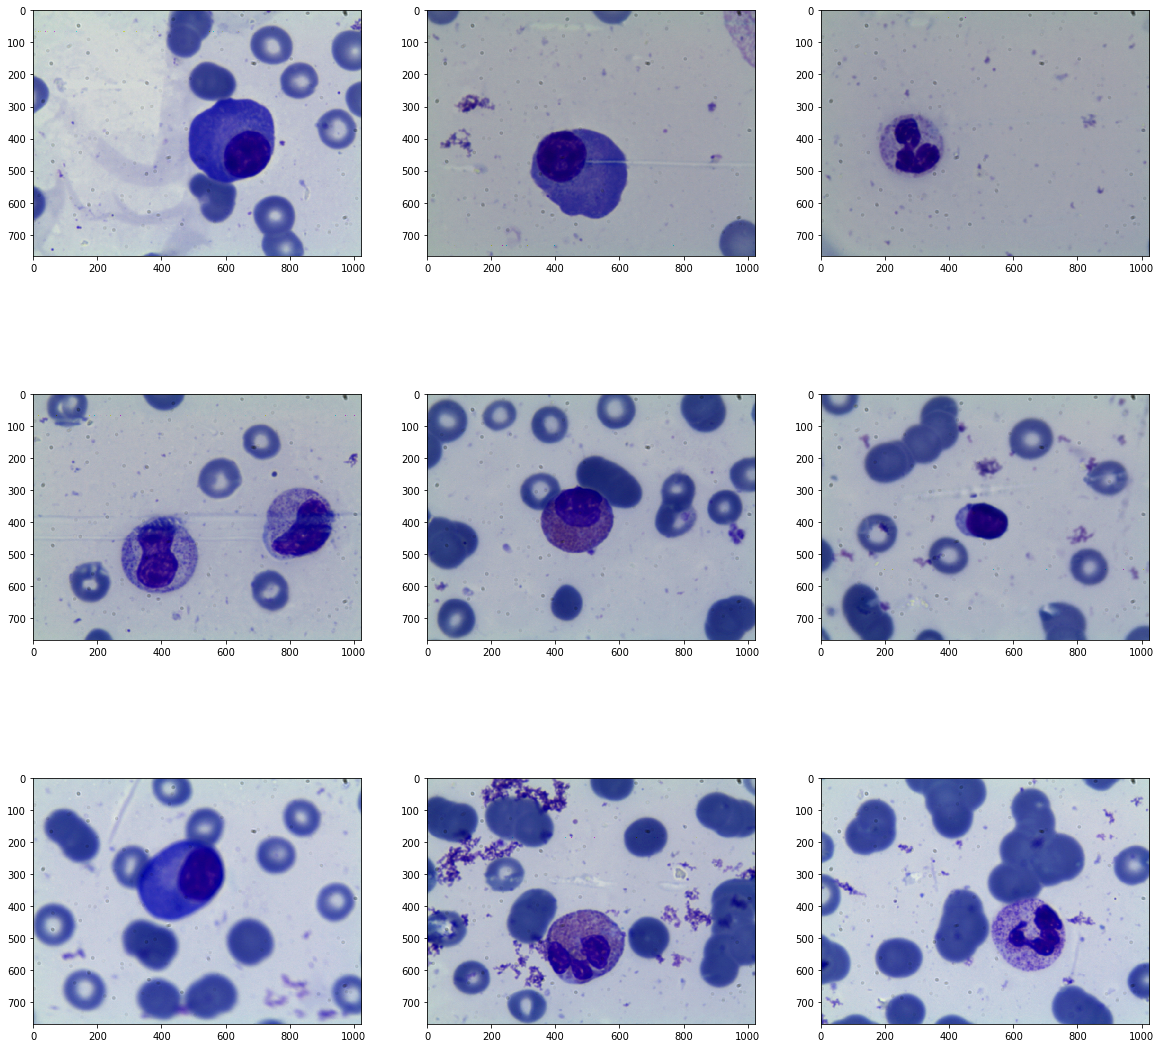

In [8]:
fig=plt.figure(figsize=(20, 20))
columns = 3
rows = 3
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(test_x[i-1].compute(), cmap=plt.get_cmap('gray'))
plt.show()

/home/skyolia/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


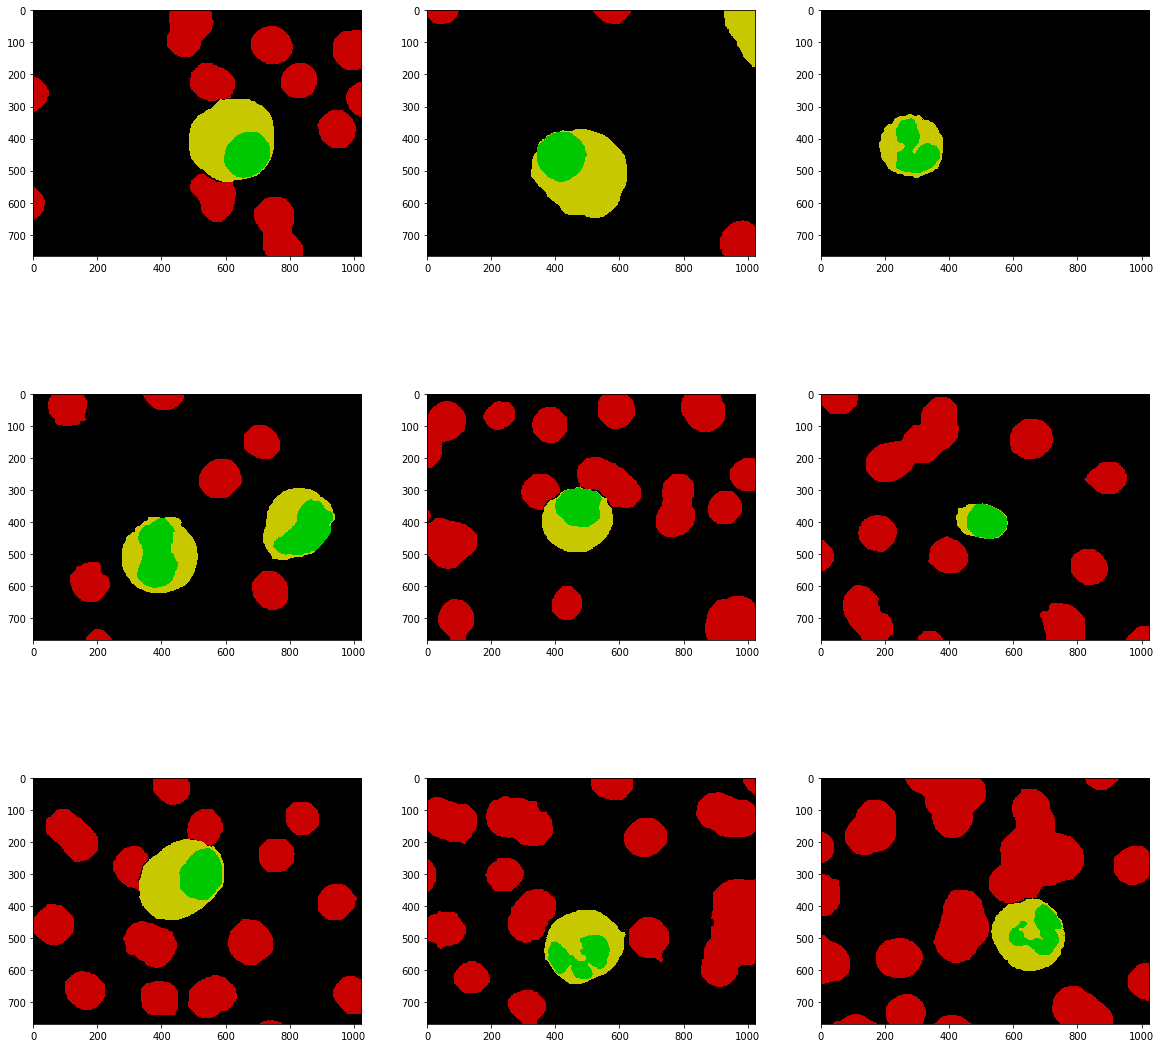

In [10]:
fig=plt.figure(figsize=(20, 20))
columns = 3
rows = 3
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(colored_test_y[i-1].compute(), cmap=plt.get_cmap('gray'))
plt.show()

/home/skyolia/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


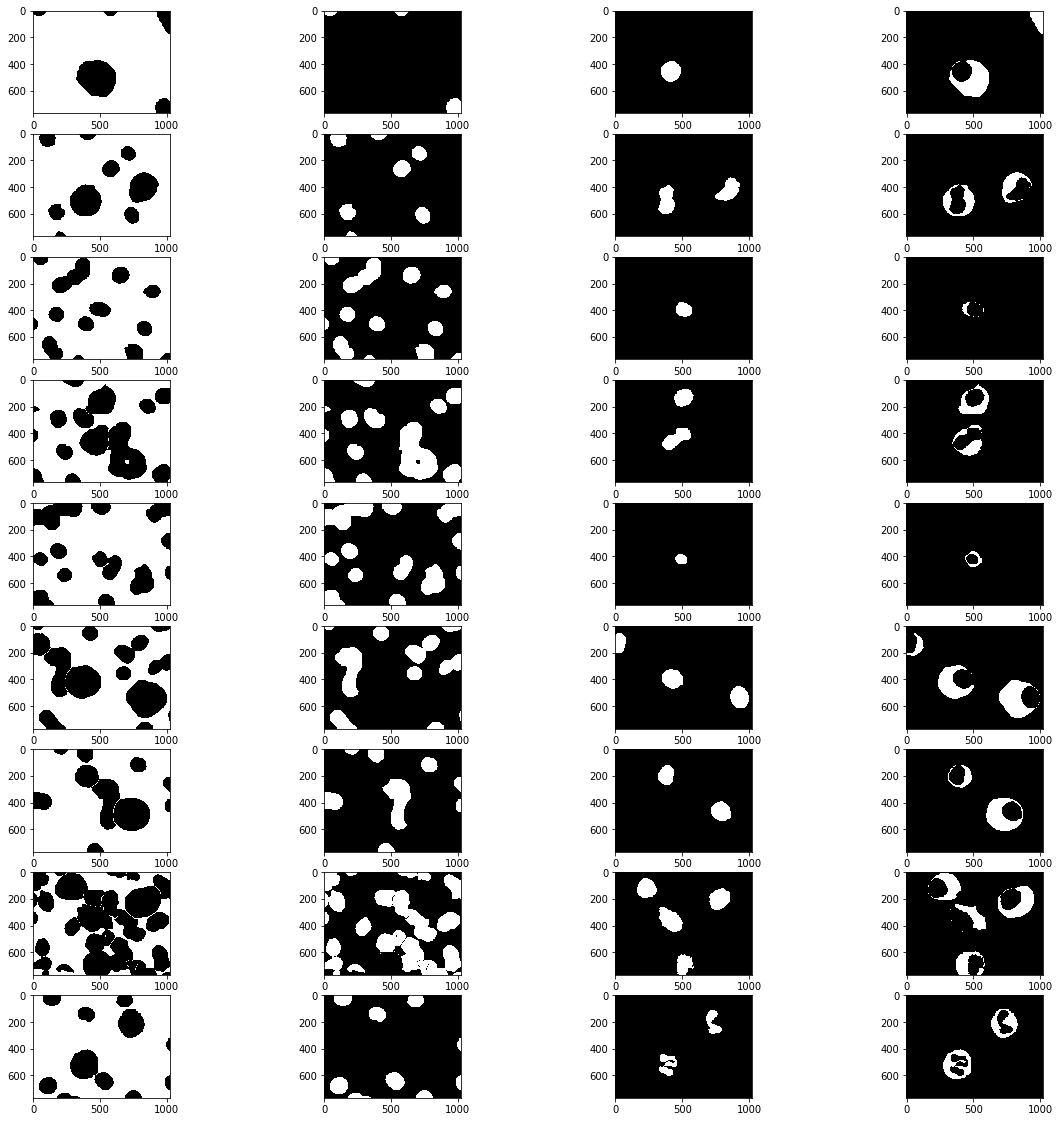

In [12]:
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 9
k = 1
for i in range(rows):
    for j in range(columns):
        fig.add_subplot(rows, columns, k)
        k+=1
        plt.imshow(test_y[i, :, :, j].compute(), cmap=plt.get_cmap('gray'))
plt.show()

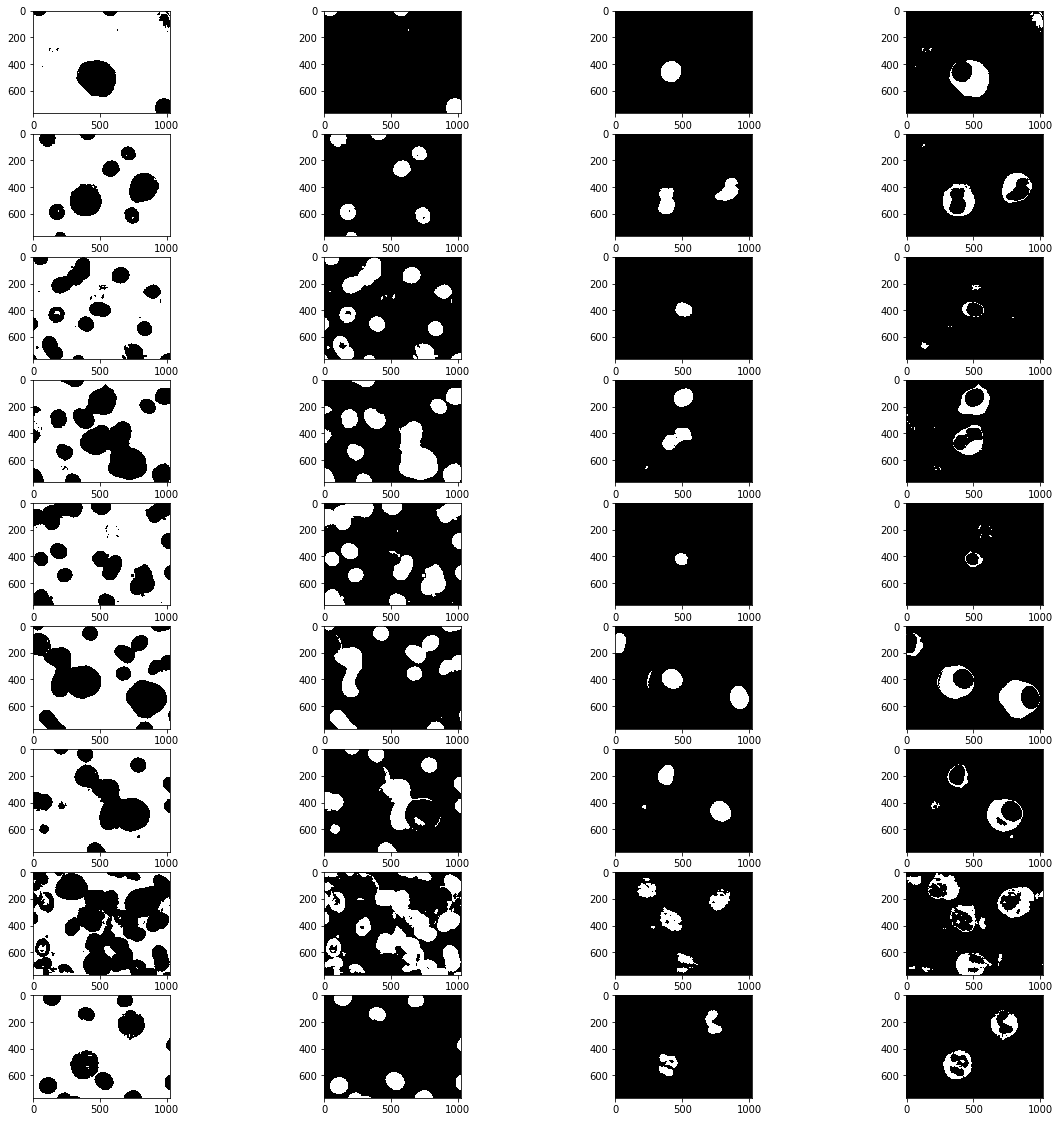

In [14]:
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 9
k = 1
for i in range(rows):
    for j in range(columns):
        fig.add_subplot(rows, columns, k)
        k+=1
        plt.imshow(pred[i, :, :, j], cmap=plt.get_cmap('gray'))
plt.show()

In [11]:
def onehot_to_rgb(x, color_dict):
    rgb, arg_max = np.zeros(tuple(list(pred.shape[0:3]) + [3])), np.argmax(x, axis=-1)
    for color in color_dict.keys():
        rgb = np.where((arg_max==color)[:, :, :, np.newaxis], color_dict[color], rgb)
    return rgb
color_dict = {0: np.broadcast_to([0, 0, 0], (1, 1, 3)), 1:np.broadcast_to([200, 0, 0], (1, 1, 3)), 
              2: np.broadcast_to([0, 200, 0], (1, 1, 3)), 3:np.broadcast_to([200, 200, 0], (1, 1, 3))}
rgb = onehot_to_rgb(pred, color_dict)
rgb.shape

(18, 768, 1024, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


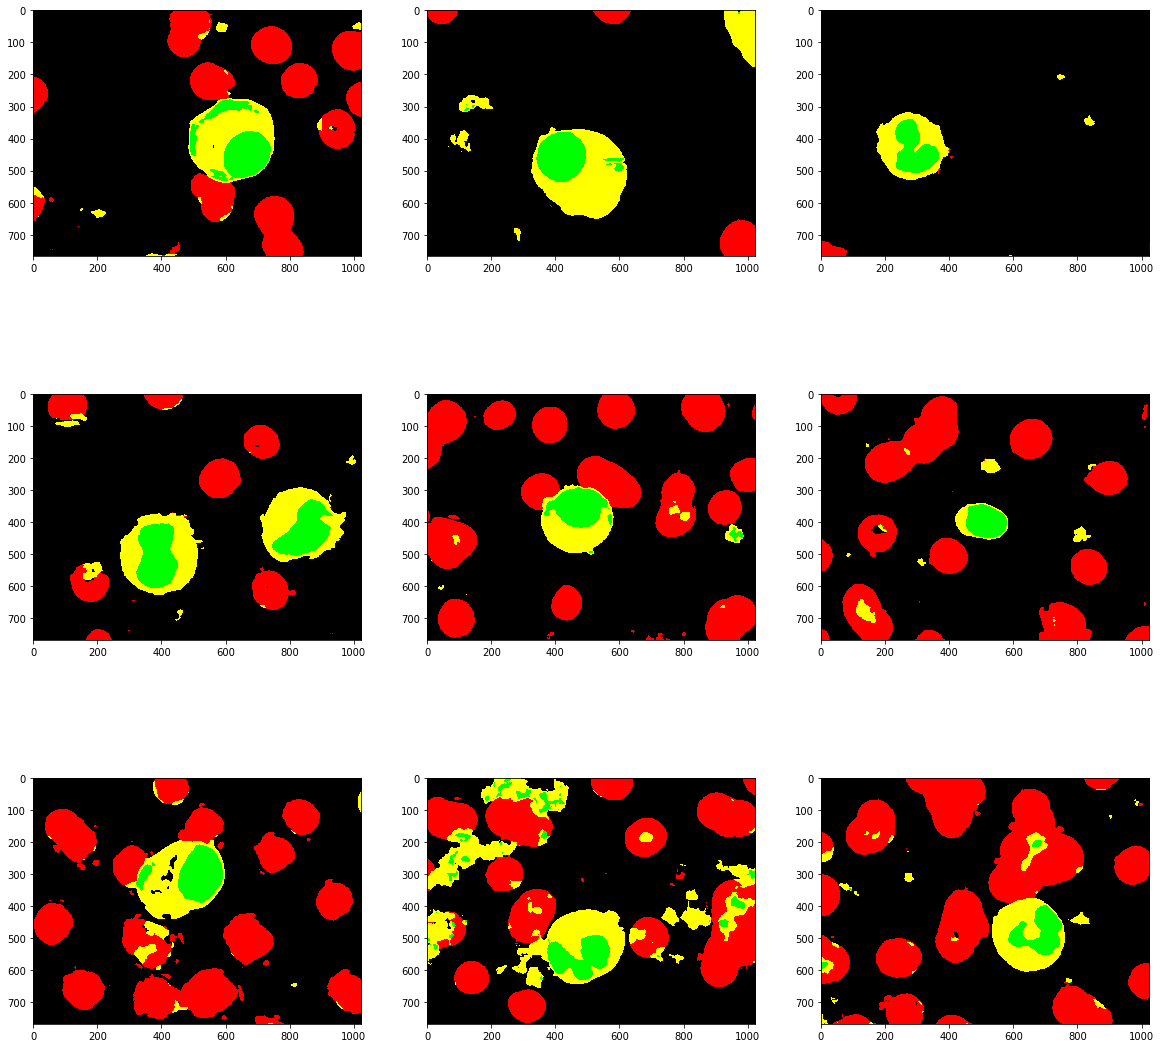

In [12]:
fig=plt.figure(figsize=(20, 20))
columns = 3
rows = 3
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(rgb[i-1], cmap=plt.get_cmap('gray'))
plt.show()